# Project Milestone 3
> CS-401 - Applied Data Analysis

> *Group Padawan - Fall 2024*

>*Martin Catheland*, *Maxime Ducourau*, *Léopold Henry*, *Jean Perbet*, *Mehdi Zoghlami*

This notebook is an analysis of the [YouNiverse](https://zenodo.org/records/4650046) dataset, which contains data about **137k** english-speaking [YouTube](https://youtube.com) channels having more than **10k** subscribers, and their **73M** videos, uploaded between **2005** and **2019**. 

We chose to focus on the **gaming** category, which is one of the most popular on YouTube. We will address the following **research questions**:
- What are the most popular games on YouTube?
- Is there a link between real-world gaming events and releases, and the popularity of games on YouTube?
- What are the most linked communities in the gaming category?

Due to the considerable size of the dataset, we pre-filtered the original dataset to only keep the **gaming videos**, their **comments**, the **channels** that have uploaded at least one video in the gaming category and their **time-series**. We also took advantage of it to remove some useless / heavy-weight fields.

This pre-filtering is available in the notebook `prefiltering.ipynb`. Below is a summary of the datasets at our disposal, after pre-filtering.

| File | Description | Fields |
| --- | --- | -- |
| `gaming_videos.tsv` | Videos | `title`, `tags`, `upload_date`, `view_count`, `like_count`, `dislike_count`, `duration`, `channel_id`, `display_id` |
| `gaming_comments.tsv` | Comments | `author`, `video_id`|
| `gaming_channels.tsv` | Channels | `channel_id`, `channel_name`, `subscribers` |
| `gaming_timeseries.tsv` | Channels time-series | `channel_id`, `datetime`, `views`, `delta_views`, `subs`, `delta_subs`, `videos`, `delta_videos` |

It is important to notice that we will use the [`polars`](https://pola.rs) library for large datasets (i.e. for videos metadata and comments) throughout this notebook, which is a blazingly fast data frame library allowing lazy evaluation and parallel processing. For cells which take a long time to run, we provide the expected time to run the cell as a comment.

In [7]:
# Imports

# DataFrames
import pandas as pd
import polars as pl

# Utils
import sys
sys.path.insert(0, '../')
from src.utils import *

# Data manipulation
from src.gaming_representation import *
from src.tags import *
from src.assign_games import *
from src.top_3_games import *
from src.games_genre import *
from src.timeseries import *
from src.communities import *

# Visualization
from src.plotting import *

# Exporting
from src.exporting import *

# Progress tracking
from tqdm import tqdm
tqdm.pandas()

# Turn off cell outputs warnings
import warnings
warnings.filterwarnings("ignore")

# Youniverse paths
VIDEOS_PATH = "../data/youniverse/filtered/gaming_videos.tsv"
CHANNELS_PATH =  "../data/youniverse/filtered/gaming_channels.tsv"
TIMESERIES_PATH = "../data/youniverse/filtered/gaming_timeseries.tsv"
COMMENTS_PATH =  "../data/youniverse/filtered/gaming_comments.tsv"

# Feather file for videos metadata
VIDEOS_FEATHER_PATH = "../data/youniverse/original/yt_metadata_helper.feather"

# Additional datasets paths
GAMES_PATH = "../data/games.csv"
ESPORTS_PATH = "../data/esports_tournaments.csv"
WORDS_PATH = "../data/words_alpha.txt"

# Random seed for reproducibility
RANDOM_STATE = 1

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Gaming videos representation

Firstly, we would like to display the distribution of `Gaming` videos in the Youniverse dataset. We need the **category of all videos** to do so (~73 millions), thus we cannot use the filtered gaming videos data contained in `gaming_videos.tsv` yet. Since the raw data takes a lot of space because of text descriptions (around **100 Go**), we prefer to use the `.feather` file format to load the data.

In [8]:
videos_metadata_df = pd.read_feather(VIDEOS_FEATHER_PATH, columns=['categories'])

videos_metadata_df

,categories
0,Film & Animation
1,Film & Animation
2,Film & Animation
3,Film & Animation
4,Film & Animation
...,...
72924789,News & Politics
72924790,News & Politics
72924791,News & Politics
72924792,News & Politics


We want to obtain the proportion of **each category** in the dataset. Since there are a lot of very small categories, we will add a slight post-processing and group every category that has less than **3%** of the total videos into a new category called `Other`, to have a more readable graph.

In [9]:
pie_chart_df = process_category_percentages(videos_metadata_df)

pie_chart_df

,value
categories,
Gaming,18.81
Entertainment,16.83
News & Politics,12.18
Music,11.39
People & Blogs,9.48
Sports,5.97
Howto & Style,5.44
Education,5.20
Science & Technology,3.30


In [10]:
# Reset the index to make 'categories' a column
pie_chart_export_df = pie_chart_df.reset_index()

# Rename 'categories' to 'name'
pie_chart_export_df = pie_chart_export_df.rename(columns={'categories': 'name'})

# Export to JSON with only 'name' and 'value' (no index)
pie_chart_export_df[['name', 'value']].to_json('../data/youniverse/filtered/pie_chart.json', orient='records')


`Gaming` is the most popular category, with close to **20%** of videos. It is great for our further analysis to have such a large amount of data, since it will allow us to have a more accurate representation of the gaming community on YouTube.

As a sanity check, we ensure that the sum of the proportions of the categories is equal to **100%**.

In [11]:
assert pie_chart_df['value'].sum() == 100

Now, we can move on to the **plotting** part!

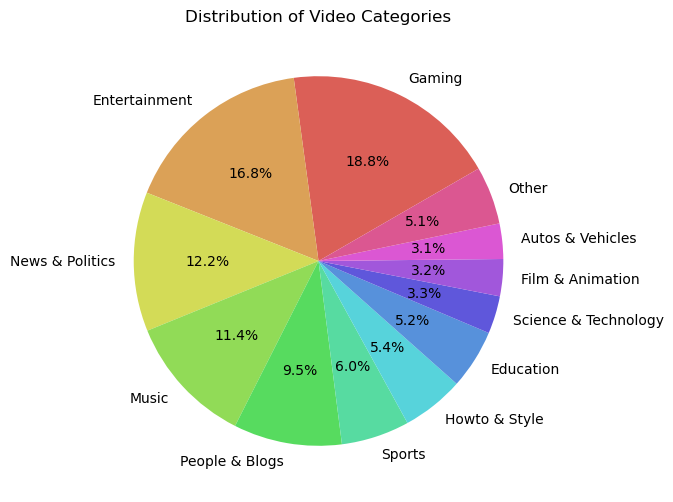

In [12]:
plot_category_pie_chart(pie_chart_df)

Let's now focus on only the `Gaming` category, and load the required filtered data in some data frames. We will use `pandas` for the channels metadata, but we'll switch to `polars` for both the videos metadata and the channels timeseries since they are quite massive.

In [13]:
channels_df = pd.read_csv(CHANNELS_PATH, sep="\t")

In [14]:
# ~2s
timeseries_df = pl.read_csv(TIMESERIES_PATH, separator="\t")

In [15]:
# ~30s
videos_df = pl.read_csv(VIDEOS_PATH, separator='\t')
len(videos_df)

13720303

There are $13\text{M}+$ videos we can leverage, that's quite a good knowledge base!

## Videos duration

We start by plotting the videos duration distribution to have a better understanding of the content we'are studying.

We will sample $1\text{M}$ videos so as to handle a more reasonable input when plotting. This will preserve the original distribution of our dataset since the [Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers) and the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) guarantee that a sufficiently large sample does not alter too much the properties of the data.

In [16]:
# ~45s
videos_sample_df = videos_df.sample(n=1e6, seed=RANDOM_STATE)

We select the value below which $95\%$ of the `duration` values in the dataset fall as our upper bound to select rows. This way, we focus on the majority of the data and avoid the influence of extreme outliers, providing a clearer visualization of the distribution. This helps ensure that the histogram is not skewed by a small number of unusually high values, such as $10$-hour videos. 

In [4]:
videos_sample_df

title,tags,upload_date,view_count,like_count,dislike_count,duration,channel_id,display_id
str,str,str,f64,f64,f64,i64,str,str
"""Ugly As Hell :: Limbo :: Episo…","""Hell (Art Subject),Limbo,Limbo…","""2013-10-17 00:00:00""",12.0,3.0,0.0,1357,"""UCEYST4brt-PrEEZ97r8FU7w""","""0nI347muNZg"""
"""meme.exe (mcpe)""","""mcpe,meme,minecraft meme,memes…","""2019-05-27 00:00:00""",2306.0,230.0,14.0,398,"""UCpowCAl4XV_hTQSYQpMWF6A""","""P2w3uE2Jglc"""
"""GIRLFRIEND PLAYS FORTNITE PARK…","""fortnite,fortnite creative,for…","""2019-01-23 00:00:00""",5577.0,202.0,10.0,680,"""UChu76GUurlwcAvkMy4CldlQ""","""B7T9CXhxxgM"""
"""CSR Classics – Official Trai…","""Drag,Racing,Racer,Race,Driving…","""2014-05-29 00:00:00""",102416.0,644.0,46.0,52,"""UCZhBz-0GhnSKfGNf0xhTIzw""","""w6E2pjSsU1s"""
"""LEGO Ninjago WU-CRU - Gameplay…","""tapgameplay,ios,android,iphone…","""2017-02-06 00:00:00""",22199.0,60.0,12.0,939,"""UCRu4Stv2mLoUaLw2kWsowSA""","""b5t9BmIvYfI"""
…,…,…,…,…,…,…,…,…
"""The Binding of Isaac: Antibirt…","""let's play,binding of isaac an…","""2017-09-13 00:00:00""",1919.0,60.0,1.0,2821,"""UCEplz-lZVwLZUzbg6r4S4KQ""","""ZYUs2OijAp0"""
"""Kingdom Hearts 15th Anniversar…","""LimitForm72,Kingdom Hearts 2,K…","""2017-03-29 00:00:00""",931.0,68.0,0.0,309,"""UCYPMWe09F1YCHgWhjIqq58w""","""cSVUpzHolpg"""
"""PS4 | Spiderman 2018 Playthrou…","""great,game,Lunatic,PUBG,Lunati…","""2018-09-08 00:00:00""",1902.0,168.0,5.0,6767,"""UC0uaZ-AifjEzM48rgxaSHxA""","""LwbKu_V2FNE"""


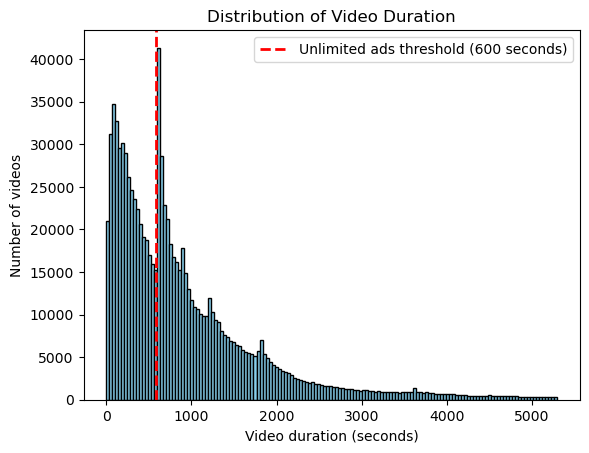

In [5]:
plot_video_duration_histogram(videos_sample_df)

It's very interesting here to notice the peak at $10$ minutes, which at the period captured by this dataset, corresponded to the **minimum duration** of a video that allowed content creators to freely decide the number of ads they could insert, maximizing their videos' monetization.

## Most common tags & titles

Now, let's dive deeper into our `title` and `tags` field. We noticed that the `tags` field is a list of tags, where they're separated by a comma. What would be super interesting to do is extracting all different tags and see which ones are the most common. We carry on with our sample of the data.

In [6]:
# ~20s
tags = get_tags(videos_sample_df)

# Take 2000 first tags
tags = tags[:500]

We would like to generate a wordcloud of the most common tags. A wordcloud is a visual representation of text data, where the size of each word indicates its **frequency or importance**.

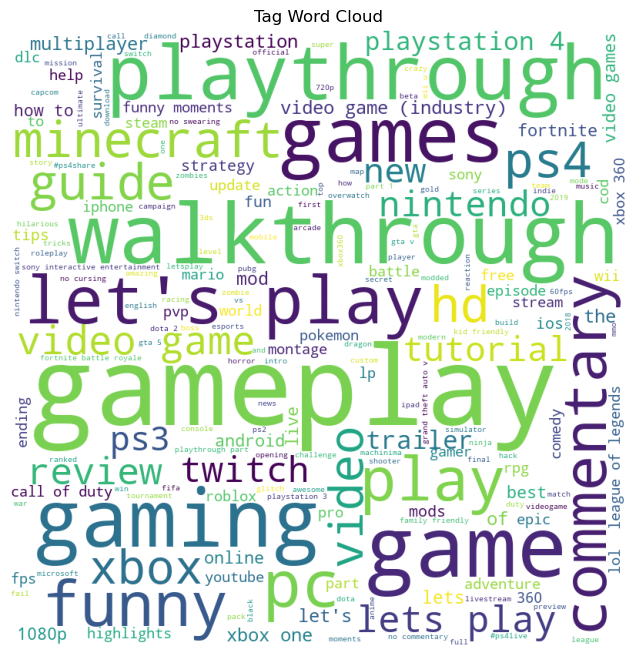

In [20]:
# ~3s
tag_frequencies = generate_tag_wordcloud(tags)

## Assign games

Next part will involve linking videos to the game they're about, and channels to the game they publish the most videos about. This means we must first load a games dataset, namely this one available on [kaggle](https://www.kaggle.com/datasets/matheusfonsecachaves/popular-video-games). We will only keep the ~$1\text{k}$ most popular games, since we assume they represent the vast majority of YouTube gaming videos.

In [21]:
games_df = pd.read_csv(GAMES_PATH, index_col=0).drop_duplicates("Title").reset_index(drop=True)

games_df.head(3)

,Title,Release_Date,Developers,Summary,Platforms,Genres,Rating,Plays,Playing,Backlogs,Wishlist,Lists,Reviews
0,Elden Ring,"Feb 25, 2022","['FromSoftware', 'Bandai Namco Entertainment']","Elden Ring is a fantasy, action and open world...","['Windows PC', 'PlayStation 4', 'Xbox One', 'P...","['Adventure', 'RPG']",4.5,21K,4.1K,5.6K,5.5K,4.6K,3K
1,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",The Legend of Zelda: Breath of the Wild is the...,"['Wii U', 'Nintendo Switch']","['Adventure', 'Puzzle']",4.4,35K,3.1K,5.6K,3K,5.1K,3K
2,Hades,"Dec 07, 2018",['Supergiant Games'],A rogue-lite hack and slash dungeon crawler in...,"['Windows PC', 'Mac', 'PlayStation 4', 'Xbox O...","['Adventure', 'Brawler', 'Indie', 'RPG']",4.3,25K,3.5K,7.3K,4K,3.2K,2.1K


We'll use the `Plays` feature to estimate the popularity of the games, and we'll use a cutoff of $2\text{k}$ games to keep.

In [22]:
games_df = filter_and_sort_games_by_plays(games_df, cutoff=2000)

games_df.head(3)

,Title,Release_Date,Developers,Summary,Platforms,Genres,Rating,Plays,Playing,Backlogs,Wishlist,Lists,Reviews
5,Minecraft,"Nov 18, 2011",['Mojang Studios'],Minecraft focuses on allowing the player to ex...,"['Windows PC', 'Mac', 'Linux']","['Adventure', 'Simulator']",4.3,38K,2.1K,1.3K,265,2.6K,2.7K
1,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",The Legend of Zelda: Breath of the Wild is the...,"['Wii U', 'Nintendo Switch']","['Adventure', 'Puzzle']",4.4,35K,3.1K,5.6K,3K,5.1K,3K
23,Grand Theft Auto V,"Sep 17, 2013","['Rockstar North', 'Rockstar Games']",Grand Theft Auto V is a vast open world game s...,"['Windows PC', 'Xbox 360', 'PlayStation 4', 'P...","['Adventure', 'Shooter']",3.8,35K,958,3.7K,757,2.4K,1.7K


Then, we'll remove game names that are too short and those that are common english names, as they are likely to be noise. We pick the list of common english names [here](https://github.com/dwyl/english-words).

In [23]:
games_df = filter_games_by_title(games_df, WORDS_PATH, min_title_length=4)

Some video games are just specific versions of other games, see for instance the *Tetris* example.

In [24]:
games_df[games_df["Title"].str.contains("Modern Warfare 2")]

,Title,Release_Date,Developers,Summary,Platforms,Genres,Rating,Plays,Playing,Backlogs,Wishlist,Lists,Reviews
63,Call of Duty: Modern Warfare 2,"Nov 10, 2009","['Infinity Ward', 'Activision']",Call of Duty: Modern Warfare 2 is a first-pers...,"['Windows PC', 'Mac', 'Xbox 360', 'PlayStation...",['Shooter'],3.8,16K,42,767,332,1.2K,531
1368,Call of Duty: Modern Warfare 2 Campaign Remast...,"Mar 31, 2020","['Activision', 'Beenox']",TheÂ Call of Duty: Modern Warfare 2Â Campaign ...,"['Windows PC', 'PlayStation 4', 'Xbox One']",['Shooter'],3.7,1.9K,19,373,125,217,124


Since we're not interested in **specific versions** but rather in the game itself, we will **remove** all games that are a superstring of another game.

In [25]:
games_df = filter_unique_games(games_df)

Since the titles and tags are quite noisy and may contain a lot of irrelevant information, we searched for a good and effective way to extract the game names from the title and tags field.

- We first tried to use **TF-IDF** embeddings, but it did not yield satisfactory results are rare words were given too much importance : a title containing the words *mafia* and *minecraft* would be assigned to the game *mafia ii*, even though it is more likely to be about *minecraft*.

- We then tried to use **Sentence Transformers** to embed the game names and the titles/tags, and then compute the cosine similarity between them. It did not yield satisfactory results either.

- What works the best is in fact quite simple. We lowercase and remove punctuation from all video games names, titles and tags, and then we start by looking if a game name is entirely contained in the video title. If it is, we assign the video to this game. If it is not, we look if a game name is entirely contained in one of the tags. If there is only one game name, we assign the video to this game. Otherwise, if there is no game or several games in the tags, we do not assign the video. This way, we can assign a game to ~$50\%$ of the videos.

We tried to also use game initials (e.g. *LoL* for *League of Legends*, *gta* for *Grand Theft Auto V*, etc.) but it did not really improve our classification since most of the time the full game name is also specified next to its initials in the tags.

In [26]:
# ~20s
processed_videos_sample_df, games_title = preprocess_video_data(videos_sample_df, games_df, preprocess_name)

100%|██████████| 1131/1131 [00:00<?, ?it/s]


In [27]:
# ~2min
with_game_df = classify_videos_with_games(processed_videos_sample_df, games_title)

Classifying videos: 100%|██████████| 1000000/1000000 [03:05<00:00, 5380.13it/s]

Percentage of classified games over the sample: 49.77%


In [28]:
with_game_df.head(3)

title,tags,upload_date,view_count,like_count,dislike_count,duration,channel_id,display_id,video_game
str,str,str,f64,f64,f64,i64,str,str,str
"""memeexe mcpe""","""mcpe meme minecraft meme memes…","""2019-05-27 00:00:00""",2306.0,230.0,14.0,398,"""UCpowCAl4XV_hTQSYQpMWF6A""","""P2w3uE2Jglc""","""minecraft"""
"""girlfriend plays fortnite park…","""fortnite fortnite creative for…","""2019-01-23 00:00:00""",5577.0,202.0,10.0,680,"""UChu76GUurlwcAvkMy4CldlQ""","""B7T9CXhxxgM""","""fortnite"""
"""weapon upgrades 7 days to die…","""7 days to die 7 days to die ga…","""2018-06-30 00:00:00""",42040.0,1131.0,21.0,1175,"""UC-wXkB3v0N9MB2Y9rR2Pbkg""","""rNmWITSSUjQ""","""7 days to die"""


Here are the top-$10$ most played games on YouTube.

In [29]:
posting_rate_df = game_percentage(with_game_df).head(10)

posting_rate_df

video_game,percentage
str,f64
"""minecraft""",11.24
"""fortnite""",5.51
"""call of duty""",5.43
"""league of legends""",3.42
"""roblox""",3.02
"""grand theft auto""",2.99
"""dota 2""",2.18
"""super smash bros""",1.36
"""final fantasy""",1.17


Using this new knowledge, we will try to recover the main game of each channel, i.e. the game there are the most videos about.

In [30]:
top_games_per_channel_df = get_top_game_per_channel(with_game_df, channels_df)

top_games_per_channel_df.head()

channel_id,top_game
str,str
"""UCjeK0f1QV53_GWzijUdJ2cw""","""fortnite"""
"""UC7gvvlCOveOlTStxUSbVCmQ""","""grand theft auto"""
"""UC6Oklv1Im_alv36sadnCe2A""","""fortnite"""
"""UCiw7oQnb47XCPQn8oFf71SA""","""fortnite"""
"""UCHOzL6sB82Pqk1WSjxpEiMA""","""subway surfers"""


Let's now explore some statistics about the channels and their main video game.
We will see which games are **the most frequently** used as **main game** in our sample of **channels**.

In [31]:
# Group by top_game, count occurrences
top_games_df = (
    top_games_per_channel_df.group_by("top_game")
    .count()
    .sort("count", descending=True)
)

Let's quickly get this statistic through a **percentage**!

In [32]:
calculate_percentage(top_games_df, "count").head(10)

top_game,count,percentage
str,u32,f64
"""fortnite""",2360,12.61
"""minecraft""",1971,10.53
"""call of duty""",1237,6.61
"""roblox""",794,4.24
"""grand theft auto""",683,3.65
"""league of legends""",517,2.76
"""super smash bros""",257,1.37
"""world of warcraft""",225,1.2
"""resident evil""",203,1.08


We clearly see that there are 3 games that are the main game of way more channels than the others, namely *Minecraft*, *Fortnite* and *Call of Duty*. Let's discover some **stats** about these 3 games particularly.

# Top 3 Games

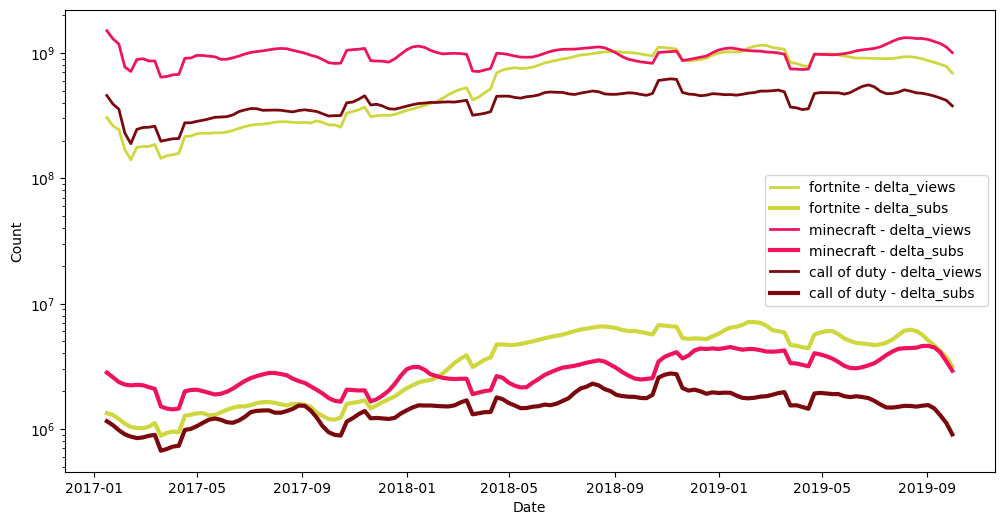

In [33]:
target_games = [x for x in top_games_df.head(3)["top_game"]]

plot_top_game_timeseries(
    top_games_per_channel_df,
    timeseries_df,
    games=target_games,
    metrics=["delta_views", "delta_subs"],
    cutoff="2017-01-01",
    yscale="log"
)

We want also to add few metrics about each game for our datastory, such as:
- The **dedication rate**, defined as the number of channels that have this game as their main game, over the total number of channels that have at least one video on this game.
- The **likes/dislikes ratio**, defined as the total number of likes over the total number of dislikes for all videos on this game.
- The **posting rate**, defined as the number of videos on this game over the total number of videos in the dataset with a game assigned.

We start by computing the **dedication rate** for each game.

In [34]:
game_counts_per_channel = count_videos_per_game(with_game_df)

game_counts_per_channel.head(3)

channel_id,video_game,video_count
str,str,u32
"""UChkYqBSmrYsPjOTK2N4pdWg""","""league of legends""",2747
"""UCHORW8bOKFCeS_ipezw4uKA""","""dota 2""",755
"""UCN9WmtfPT0BA_I3pHq_HcbA""","""angry birds""",683


Now we have a DataFrame mapping every channel to one or plenty video games, and the associated count of videos for each game. We can now compute the **percentage of videos** for each game.

In [35]:
dedication_ratio_df = calculate_game_channel_percentage(
    game_counts_per_channel, top_games_per_channel_df, target_games
)

dedication_ratio_df.sort("percentage", descending=True).head(10)

video_game,channels_with_at_least_one_vid,channels_with_main_game,percentage
str,u32,u32,f64
"""fortnite""",4219,2360,55.94
"""minecraft""",3846,1971,51.25
"""call of duty""",3106,1237,39.83


Let's now compute the **likes/dislikes ratio** and the **posting rate** for each game.

In [36]:
like_dislikes_ratio_df = calculate_like_dislikes_ratio(with_game_df, top_games_df)

like_dislikes_ratio_df

video_game,like_dislike_ratio
str,f64
"""fortnite""",23.16
"""call of duty""",25.27
"""minecraft""",31.46


In [37]:
posting_rate_df.head(3)

video_game,percentage
str,f64
"""minecraft""",11.24
"""fortnite""",5.51
"""call of duty""",5.43


We just wanted to add a few more informations, selected by hand on our top-$3$ games. There are defined below!

In [38]:
games_info = {
    "call of duty": {
        "Release Date": "October 2003 - Now",
        "Genre": "Shooter",
        "Studio": "Activision"
    },
    "fortnite": {
        "Release Date": "July 2017",
        "Genre": "Adventure",
        "Studio": "Epic Games"
    },
    "minecraft": {
        "Release Date": "November 2011",
        "Genre": "Sandbox",
        "Studio": "Mojang"
    }
}

# Impact of real world events on channels

Each channel is assigned to a video game that we will consider as its main. Our question here is: **How does a channel's view count change when an event related to its main video game occurs?**

Let's choose some **mainstream games** associated to popular events to observe this behaviour. 

We'll start with **League of Legends (LoL)** that has world championships every year. 

In [39]:
games_timeseries_df = games_timeseries(top_games_per_channel_df, timeseries_df)

worlds_2017 = ("World Championship 2017", "2017-09-23")
worlds_2018 = ("World Championship 2018", "2018-10-01")
msi_2019 = ("MSI 2019", "2019-05-21") 
lol_event_dates = [worlds_2017, worlds_2018, msi_2019]
plot_views(games_timeseries_df, "league of legends", dates=lol_event_dates, period="M")
#views_to_json(games_timeseries_df, "league of legends", dates=lol_event_dates, period="W", output_file="lol_game_views.json")

We can clearly observe a rise in views and interest for League of Legends channels around world championship periods.

Another interesting game is **Mortal Kombat**: with the release of its 11th edition in 2019 the game generated great anticipation:

In [40]:
mk_events = [("Mortal Kombat 11 Release", "2019-04-23")]

plot_views(games_timeseries_df, "mortal kombat", dates=mk_events, period="M")

In [41]:
#Export
views_to_json(
    games_timeseries_df,
    "mortal kombat",
    dates=mk_events,
    period="M",
    output_file="mk.json",
)

One extra example is a popular game franchise called **Assasin's Creed** who has reoccuring game release and also had in 2016 a **movie release** about the franchise.

In [42]:
ac_events = [
    ("Assassin's Creed Movie Release", "2016-12-21"),
    ("Assassin's Creed Origins Release", "2017-10-27"),
]

plot_views(games_timeseries_df, game_name ="assassins creed", dates=ac_events, period="W", window=7)

## Views generated by videos given a certain game

In this section, our focus will shift from channels to **individual videos**. Each video is linked to a specific video game, allowing us to analyze how **video** content related to a particular game **generates views over time**. We will also compare these trends to relevant real-world events for deeper insights. Obviously since we only take a sample of the videos dataset the cumulative number of views will be much smaller. What really interests us here is the **trends** we see in the graphs notably the **spikes** and the **troughs**.

In [43]:
battle_royale_release = ("Battle royale mode release", "2017-09-26")
fortnite_events = [battle_royale_release]
plot_views(with_game_df, game_name="fortnite",channel = False, dates=fortnite_events, window = 4)
views_to_json(with_game_df, game_name="fortnite", dates=fortnite_events, output_file="fortnite.json", channel_views=False)

Fortnite is one of the most successful video games of the last 10 years. It became particularly **popular** after the **release of its Battle Royale** mode, which we can clearly observe in the graph.

In [44]:
fifa_15_events = [("FIFA 15 Release", "2014-09-23"),("FIFA 16 Release", "2015-09-22")]
plot_views(with_game_df, game_name="fifa 15",channel=False ,dates=fifa_15_events, window = 4)
views_to_json(with_game_df, game_name="fifa 15", dates=fifa_15_events, output_file="fifa.json", channel_views=False)

The **Fifa franchise** is also a fan favorite with one iteration of the game released per year. We can clearly see that the interest in Fifa 15 after its release and falls quickly when Fifa 16 is out.

# Genres

At this point, we know about particular games, such as the 3 top games previously mentioned. We learned about the impact of real-life events on metrics spikes. We want to begin asking ourselves about some kinds of communities. The first one that comes to mind is about **genres** of games (i.e Adventure, Shooter, RPG...)? 

Firstly, we can ask ourselves, what are the **most common genres** in video games? We need to use a dataset containing the genres of the games. It is an almost-comprehensive list of more than **41k** unique commercial video games. It is available [here](https://www.kaggle.com/datasets/matheusfonsecachaves/popular-video-games). So as to keep this study manageable, we will only focus on the first **~2k** most popular games, since we assume they represent the vast majority of YouTube gaming videos.

Let's load and merged our two datasets (videos with their assigned game, and games with their genre) to get a better understanding of the distribution of genres in the gaming videos.

In [45]:
merged_df = join_games_with_genres(games_df, with_game_df)

merged_df.head(3)

title,tags,upload_date,view_count,like_count,dislike_count,duration,channel_id,display_id,video_game,Genres
str,str,str,f64,f64,f64,i64,str,str,str,str
"""memeexe mcpe""","""mcpe meme minecraft meme memes…","""2019-05-27 00:00:00""",2306.0,230.0,14.0,398,"""UCpowCAl4XV_hTQSYQpMWF6A""","""P2w3uE2Jglc""","""minecraft""","""['Adventure', 'Simulator']"""
"""girlfriend plays fortnite park…","""fortnite fortnite creative for…","""2019-01-23 00:00:00""",5577.0,202.0,10.0,680,"""UChu76GUurlwcAvkMy4CldlQ""","""B7T9CXhxxgM""","""fortnite""","""['Adventure', 'RPG', 'Shooter'…"
"""weapon upgrades 7 days to die…","""7 days to die 7 days to die ga…","""2018-06-30 00:00:00""",42040.0,1131.0,21.0,1175,"""UC-wXkB3v0N9MB2Y9rR2Pbkg""","""rNmWITSSUjQ""","""7 days to die""","""['Adventure', 'Indie', 'RPG', …"


In [46]:
exploded_genres_df, genre_counts_df = count_genre_occurrences(merged_df)

genre_counts_df.head()

Genres,count
str,u32
"""Adventure""",229629
"""Shooter""",143147
"""RPG""",122328
"""Simulator""",102423
"""Strategy""",89037


This table gives us the number of **occurrences of each genre**. Note that we consider the number of appearences of each game so a more frequent game will have **more impact**. We can plot the result as well.

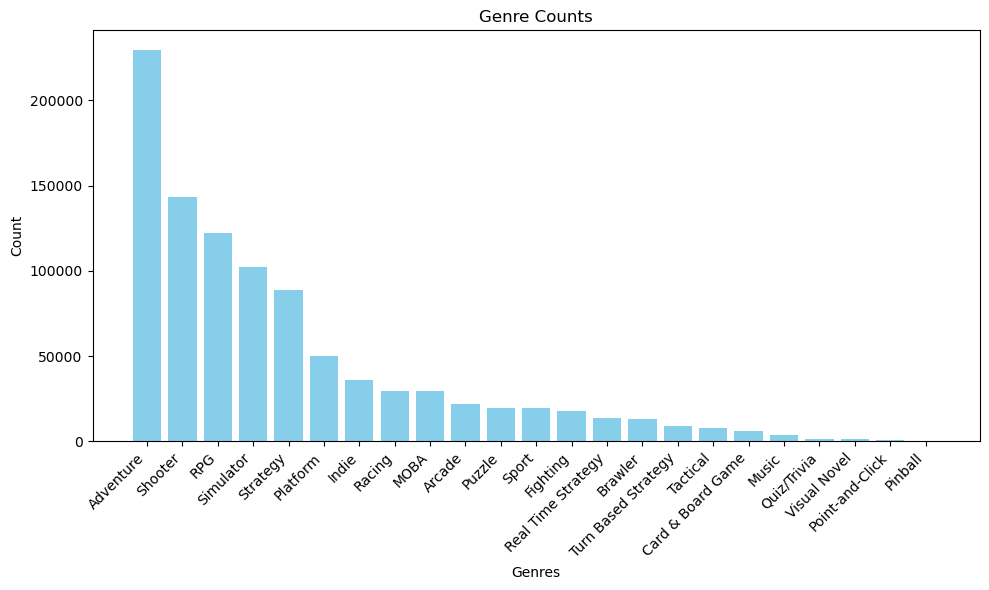

In [47]:
plot_genre_counts(genre_counts_df)

We can see that **Adventure** is the most common genre, followed by **Shooter** and **RPG**. Let's dive deeper, using timeseries data to see how the popularity of these genres evolved over time.

In [48]:
monthly_counts_by_genre = get_monthly_counts_by_top_genres(exploded_genres_df, genre_counts_df)

monthly_counts_by_genre.head()

upload_date,Genres,count
date,str,u32
2006-10-01,"""Adventure""",1
2006-11-01,"""Adventure""",1
2006-11-01,"""RPG""",1
2006-12-01,"""Adventure""",2
2007-01-01,"""Adventure""",3


We have now a dataframe containing the number of videos for each genre, for each month. We can plot the **evolution of the popularity** of the genres over time!

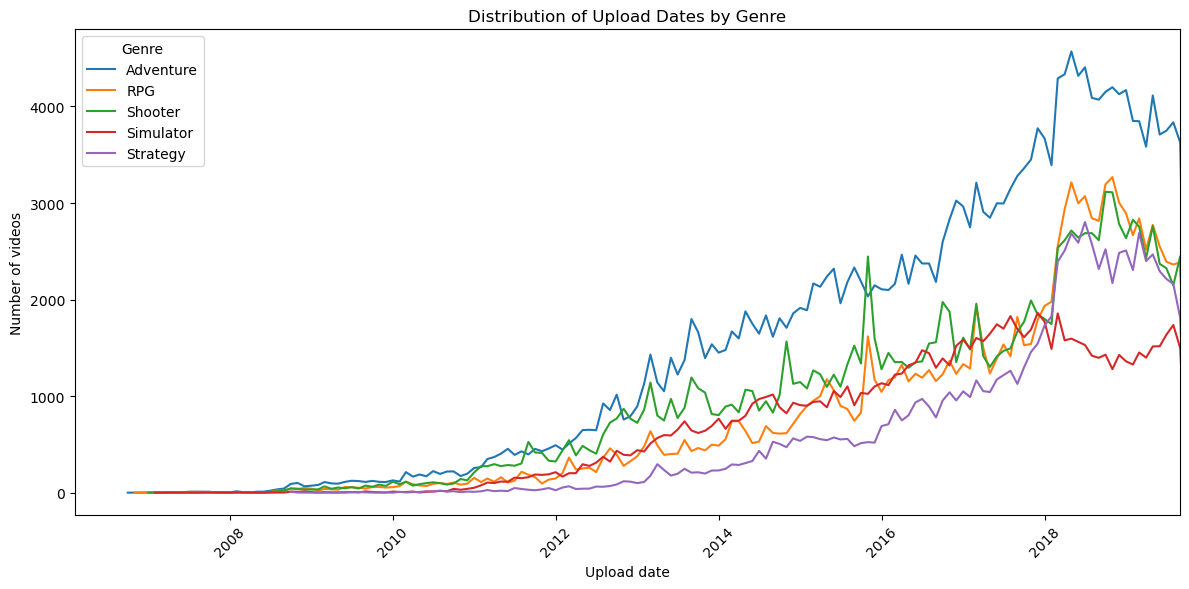

In [49]:
plot_monthly_counts_by_genre(monthly_counts_by_genre)

All 5 of the most common genres show a consistent growth trend, with uploads increasing over time. The Simulator genre experiences the **slowest growth** towards the end, while the Strategy genre sees a sharper increase in the final period. RPG and Shooter genres are the most strongly **correlated**, which is not so surprising given that many games include both genres. They both display more **spikes** than the other genres, even though their overall trends align with the others.

However, we just said that genres can be correlated, because a game can be both a Shooter and a RPG for instance. We can now plot the **co-occurence matrix** between the genres, to see which ones are the most correlated.

In [50]:
co_occurence_matrix = create_genre_cooccurrence_matrix(merged_df)

co_occurence_matrix.head()

Genres,Adventure,Arcade,Brawler,Card & Board Game,Fighting,Indie,MOBA,Music,Pinball,Platform,...,RPG,Racing,Real Time Strategy,Shooter,Simulator,Sport,Strategy,Tactical,Turn Based Strategy,Visual Novel
Genres,,,,,,,,,,,,,,,,,,,,,
Adventure,0,23,34,3,6,108,0,8,0,113,...,127,11,2,69,34,4,25,5,28,8
Arcade,23,0,5,0,14,29,0,3,0,26,...,4,11,0,16,4,6,5,1,0,0
Brawler,34,5,0,0,6,4,0,0,0,14,...,17,1,0,7,3,2,3,1,0,0
Card & Board Game,3,0,0,0,0,5,0,0,0,0,...,4,0,1,0,3,0,7,2,3,0
Fighting,6,14,6,0,0,10,0,0,0,3,...,3,1,0,2,2,4,3,1,1,0


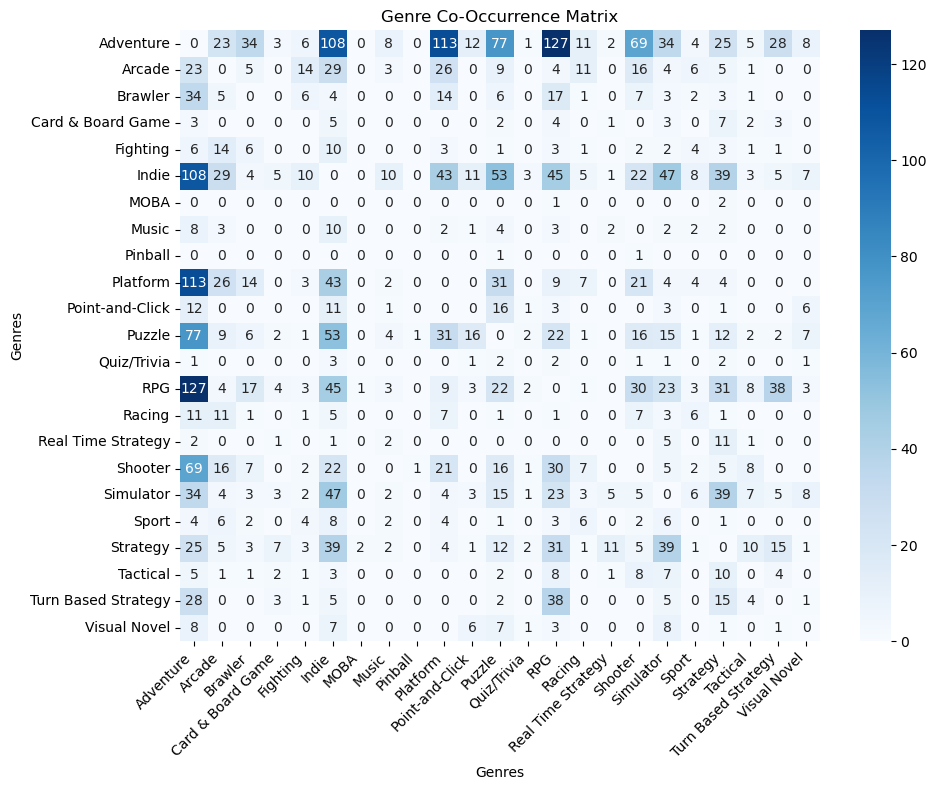

In [51]:
plot_genre_cooccurrence_heatmap(co_occurence_matrix)

In this notebook, we use a **heatmap** for visualization purposes. However, it is not the most optimal use of a heatmap due to the symmetry of the data. The heatmap highlights which genres are most frequently paired with others. A detailed analysis and presentation of the data (with a chord chart) are provided in the datastory

# Communities

Our last reasearch question is about the communities that are the most linked in the gaming category. The final goal is to have a graph where each node is either a game or a content creator, and where each edge represents a viewer who commented on videos of both nodes. We will then use the **Louvain algorithm** to detect communities in this graph. 

We will use the processed `gaming_comments.tsv` file to do so. It only contains the comments related to **gaming videos**. We will need to map each comment to a video and to a game. To proceed, we can reuse the `with_game_df` DataFrame we created earlier. Lastly, we need to map each `channel_id` to a `channel_name` to have a more readable output, and will use the channels metadata contained in `gaming_channels.tsv`.

We will start by generating the **nodes** and **edges** of the game-community 
graph. We will proceed similarly for the channel-community graph.

Let's start by loading the necessary data!   

In [52]:
comments_df = pl.read_csv(COMMENTS_PATH, separator="\t")
channels_df = pd.read_csv(CHANNELS_PATH, sep="\t")

Firstly, we want to map each video_id to the channel name. 

In [53]:
display_id_to_game = get_target_mapping(with_game_df, channels_df, target_type="game")
display_id_to_channel = get_target_mapping(with_game_df, channels_df, target_type="channel")

Now that we can link every `video_id` to a game. The next step is mapping each comment to a particular game, by merging the `with_game_df` DataFrame with the `comments_df` DataFrame, on their `video_id` field, and keeping only the `author` and `game` fields.

In [54]:
comments_with_games = map_comments_to_target(comments_df, display_id_to_game, target_type="game")

comments_with_games.head()

author,game
i64,str
16,"""fortnite"""
16,"""minecraft"""
16,"""fortnite"""
16,"""roblox"""
16,"""fortnite"""


In [55]:
sorted_game_edges = compute_edges(comments_with_games, target_type="game")
game_edges_df = create_edges_df(sorted_game_edges, target_type="game")

game_edges_df

game1,game2,weight
str,str,i64
"""minecraft""","""roblox""",12688
"""fortnite""","""minecraft""",11640
"""call of duty""","""minecraft""",7565
"""fortnite""","""roblox""",5760
"""grand theft auto""","""minecraft""",4625
…,…,…
"""tales from the borderlands""","""warframe""",1
"""mass effect""","""spelunky""",1
"""borderlands 2""","""spelunky""",1


Similarly for channels:

In [56]:
# We start by mapping comments to channels
comments_with_channels = map_comments_to_target(comments_df, display_id_to_channel, target_type="channel")

# Now compute edges between channels
sorted_channel_edges = compute_edges(comments_with_channels, target_type="channel")

# Convert edges to a DataFrame or process further
channel_edges_df = create_edges_df(sorted_channel_edges, target_type="channel")

channel_edges_df

channel1,channel2,weight
str,str,i64
"""DanTDM""","""PopularMMOs""",1867
"""PopularMMOs""","""SSundee""",896
"""DanTDM""","""stampylonghead""",863
"""DanTDM""","""SSundee""",835
"""Crainer""","""SSundee""",800
…,…,…
"""TheGamingBeaver""","""ᶻᵉᵉᵇᵒ""",1
"""Kubz Scouts""","""TheGamingBeaver""",1
"""Battlefront Knight""","""TheGamingBeaver""",1


Note that for the sake of computation time, we showed the above functions with a **small** portions of **videos** (1 million out of 13) and **comments** (100M out of 1.3B), but still pretty big in terms of raw size.

We ran once the above cells on the whole dataset and saved the results in the `data/games_edges_all.csv` file. We will now load this file to generate our graphs' insights.

Our next step is to generate a **Markov Chain Transition Matrix** heatmap between games. What it represents is the probability of transitioning from one game to another, using the weights of the edges between the games elaborated above.

In [57]:
# Load weights data
weights_games_df = pd.read_csv("../data/games_edges_all.csv")

weights_games_df.head(2)

,game1,game2,weight
0,fortnite,minecraft,8238018
1,minecraft,roblox,7883337


Unfortunately, we cannot generate our Transition Matrix on the whole games dataset, as it would be too big to handle (there are more than 1k games, thus a $1\text{k} \times 1\text{k}$ matrix). We will use the **top-20** games instead.

In [58]:
# Count the number of comments for each game
games_count = (
    with_game_df.group_by("video_game")
    .agg(pl.count("video_game").alias("count"))
    .sort("count", descending=True)
)

# Takes the top 20 games
top20games_df = games_count.head(20).to_pandas()

top20games_df

,video_game,count
0,minecraft,55931
1,fortnite,27443
2,call of duty,27024
3,league of legends,17024
4,roblox,15045
5,grand theft auto,14860
6,dota 2,10833
7,super smash bros,6749
8,final fantasy,5825
9,the sims,5644


To proceed, we now filter the game weights to include only the top 20 games, add reverse edges and self-loops for completeness, and merge weights data. Finally, we sort the results by weights and clean up unnecessary columns.

In [59]:
filtered_weights_df = process_game_weights(weights_games_df, top20games_df)

filtered_weights_df.head()

,game1,game2,weight
0,minecraft,minecraft,0
1,minecraft,fortnite,8238018
2,minecraft,call of duty,5680816
3,minecraft,league of legends,1503122
4,minecraft,roblox,7883337


We have our 400 lines of transition matrix with **reverse edges** and **self-loops**. We can now plot the heatmap!

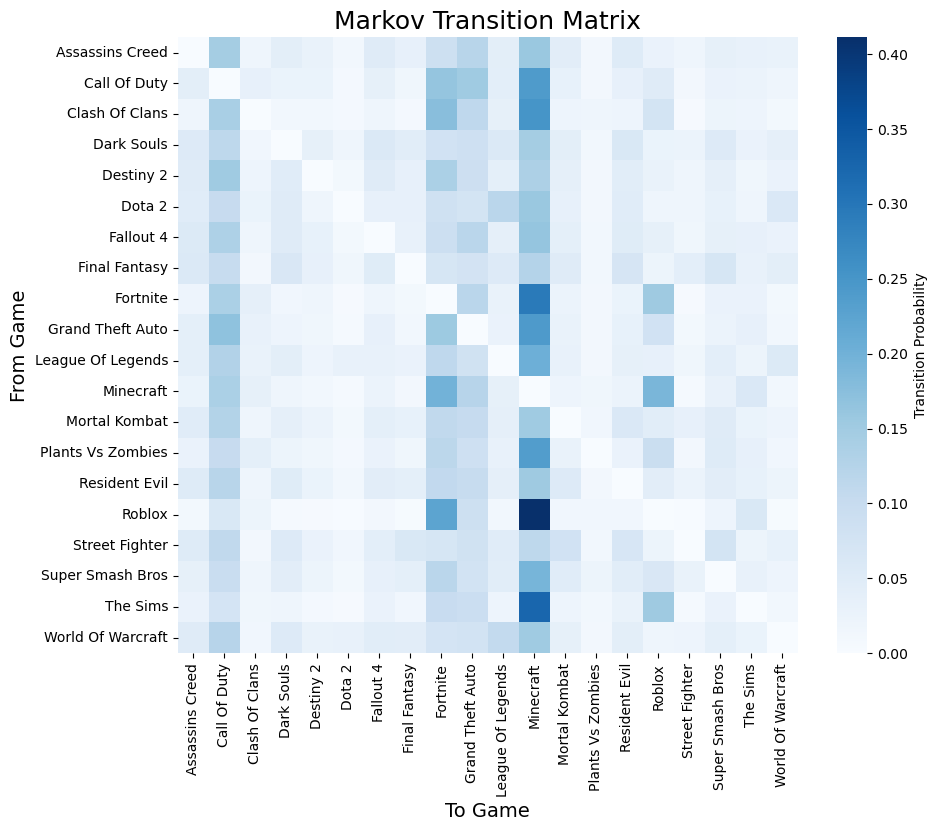

In [60]:
plot_markov_matrix(filtered_weights_df)

It is very interesting to see that we have more dark columns for our popular games, which means that the viewers for each game are also strongly linked to the most popular games (i.e *Minecraft*, *Fortnite*, *Call of Duty*, *GTA*, *Roblox*). 

We are also curious about the degrees of the nodes in the graph. We want to know if a typical node is strongly or slightly connected to the rest of the graph. We will plot the **degree distribution** of the games in the graph (note that the y-axis is in log scale).

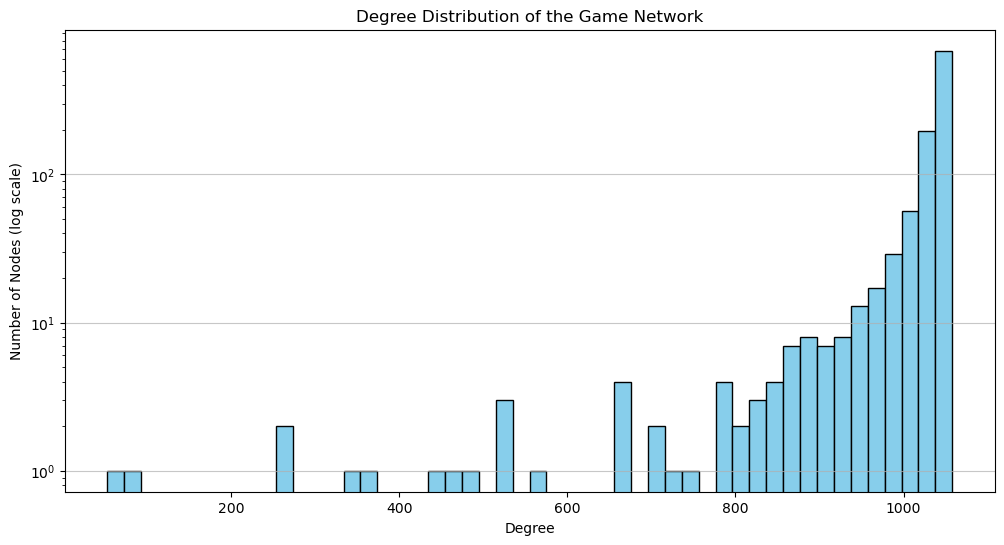

In [61]:
plot_degree_distribution(weights_games_df)

As we can see, the degree distribution is **left-skewed**, which means that most games have a **high degree** (i.e. are strongly connected to the rest of the graph), while a few games have a **low degree**. We can conclude that communities are quite **strongly linked** in the gaming category.

We can now use the **Louvain algorithm** to detect communities in the graph. We will use the `networkx` library to do so. We start with the **game-community** graph.

In [72]:
games_popularities = dict(zip(games_count["video_game"], games_count["count"]))

# Constants for adjusting weights, making the graph more readable
alpha = 0.5
beta = 0.75
threshold = 5000

# Call the function to adjust weights and display results
adjusted_edges = adjust_and_display_edges(
    pl.DataFrame(weights_games_df), games_popularities, threshold, alpha, beta
)

In [73]:
games_partition, games_positions = create_and_detect_communities(adjusted_edges, popularity)

Let's now plot the games' communities graph (which is much more beautiful in the datastory)!

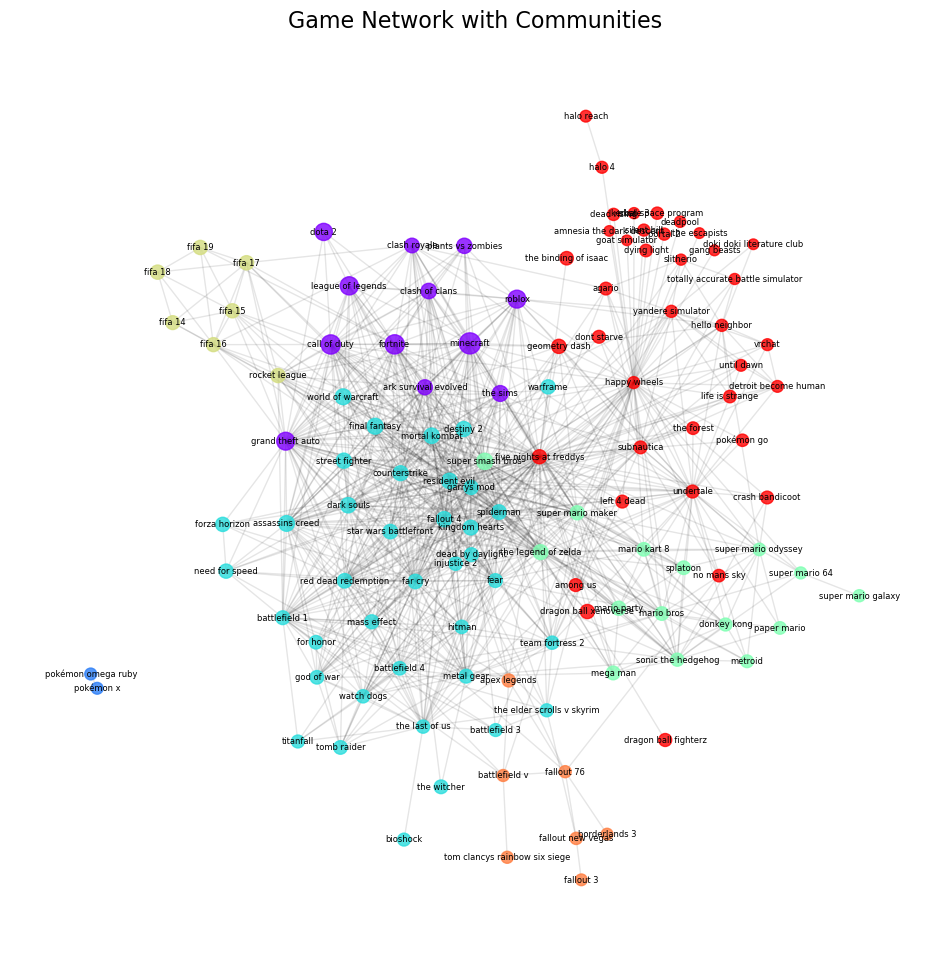

In [74]:
G_games = create_graph_from_edges(adjusted_edges)

# Plot the graph
plot_graph_with_communities(
    G_games, games_partition, games_positions, games_popularities, "game"
)

We can observe some really decent clustering with a subset of the data! You can observe all the *Nintendo* games in green, all the *Football* games in yellow...

We want to do the same for the **channel-community** graph. We will use the same approach as before, but with the `channels_edges_all.parquet` file (`.parquet` format is more efficient than `.csv` for large datasets).

Note that we proceed with the **1M** top weighted edges for the channels, for computation time reasons.

In [75]:
weights_channels_df = pl.read_parquet("../data/channels_edges.parquet").head(10000)

weights_channels_df

channel1,channel2,weight
str,str,i64
"""DanTDM""","""PopularMMOs""",331438
"""Markiplier""","""jacksepticeye""",201941
"""DanTDM""","""stampylonghead""",179555
"""PopularMMOs""","""SSundee""",166893
"""DanTDM""","""SSundee""",166667
…,…,…
"""InTheLittleWood""","""Smosh Games""",6407
"""GhostNinja""","""W2S""",6406
"""KYRSP33DY""","""SSundee""",6406


Let's first populate our popularity dictionary with the number of **subscribers** for each channel this time. Otherwise we proceed the same, just the threshold is different to have quite some nodes in the graph (again, edges are adjusted).

In [76]:
# Use the subscribers data in channels_df to create our popularity dictionary
channel_popularities = dict(
    zip(channels_df["channel_name"], channels_df["subscribers"])
)
threshold = 1500

# Call the function to adjust weights and display results
adjusted_edges = adjust_and_display_edges(
    pl.DataFrame(weights_channels_df),
    channel_popularities,
    threshold,
    alpha,
    beta,
)

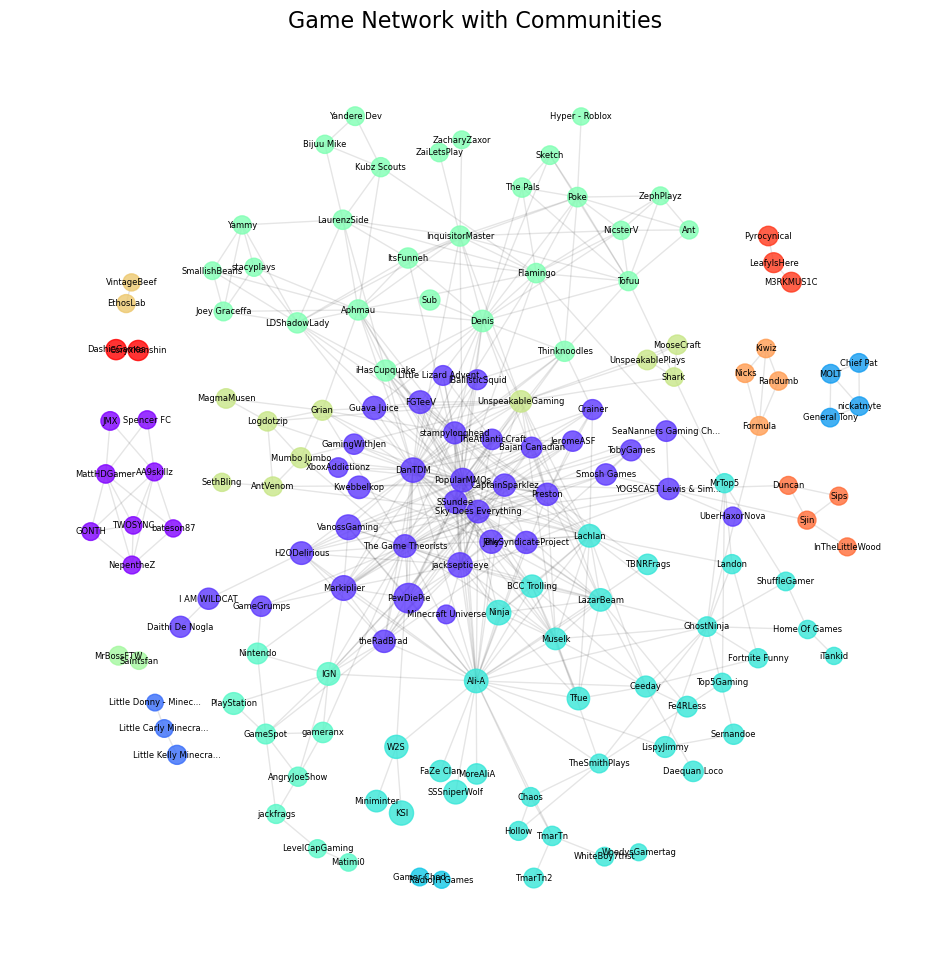

In [77]:
# Create the partition and positions for the graph
channels_partition, channels_positions = create_and_detect_communities(
    adjusted_edges, channel_popularities
)

# Add the edges to the graph
G_channels = create_graph_from_edges(adjusted_edges)

# Plot the graph
plot_graph_with_communities(
    G_channels, channels_partition, channels_positions, channel_popularities, "channel"
)

Again, we can observe **good clustering** as well for channels. The lower right-hand side of the graph seems to be the *Fortnite* community, whereas the extreme left community is the *Fifa* one. Note that the graph is much more readable and accurate in the datastory, since we only show a subset of the data here.

# Exporting

The last step is exporting everything we need for the datastory, from this notebook. We created a `export_all` function that will save all the necessary dataframes and graphs in the `../website/data/` folder.

In [85]:
export_all(
    pie_chart_df, 
    videos_sample_df,
    tags,
    games_info,
    dedication_ratio_df,
    like_dislikes_ratio_df,
    posting_rate_df,
    genre_counts_df,
    co_occurence_matrix,
    G_games,
    games_partition,
    games_popularities,
    games_positions,
    G_channels,
    channels_partition,
    channel_popularities,
    channels_positions
)

Category percentages successfully exported to ../datastory/data/category_percentages.json
Video durations JSON export completed successfully to ../website/data/video_durations.json.
Tags export completed successfully to ../website/data/word_cloud.json.
Data exported to ../website/data/top3_stats.json
Genre counts histrogram data succesfully exported to ../website/data/histogram_genres.json
Co-occurence matrix successfully exported to ../website/data/cooccurence_matrix.json
Network JSON successfully exported to ../website/data/games_network.json
Network JSON successfully exported to ../website/data/channels_network.json
